In [45]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM
from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

In [57]:
def low_temp_softmax(logits, eps):
    return (logits / eps).softmax(dim=-1)

  0%|          | 0/29 [00:00<?, ?it/s]

Testing with epsilon: 1.00e-02
Testing with epsilon: 1.00e-03
Testing with epsilon: 1.00e-04
Testing with epsilon: 1.00e-05
Testing with epsilon: 1.00e-06
Testing with epsilon: 1.00e-07
Testing with epsilon: 1.00e-08
Testing with epsilon: 1.00e-09
Testing with epsilon: 1.00e-10
Testing with epsilon: 1.00e-11
Testing with epsilon: 1.00e-12
Testing with epsilon: 1.00e-13
Testing with epsilon: 1.00e-14
Testing with epsilon: 1.00e-15
Testing with epsilon: 1.00e-16
Testing with epsilon: 1.00e-17
Testing with epsilon: 1.00e-18
Testing with epsilon: 1.00e-19
Testing with epsilon: 1.00e-20
Testing with epsilon: 1.00e-21
Testing with epsilon: 1.00e-22
Testing with epsilon: 1.00e-23
Testing with epsilon: 1.00e-24
Testing with epsilon: 1.00e-25
Testing with epsilon: 1.00e-26
Testing with epsilon: 1.00e-27
Testing with epsilon: 1.00e-28
Testing with epsilon: 1.00e-29
Testing with epsilon: 1.00e-30


C:\Users\lhall\AppData\Local\Temp\ipykernel_9340\360647573.py:117: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


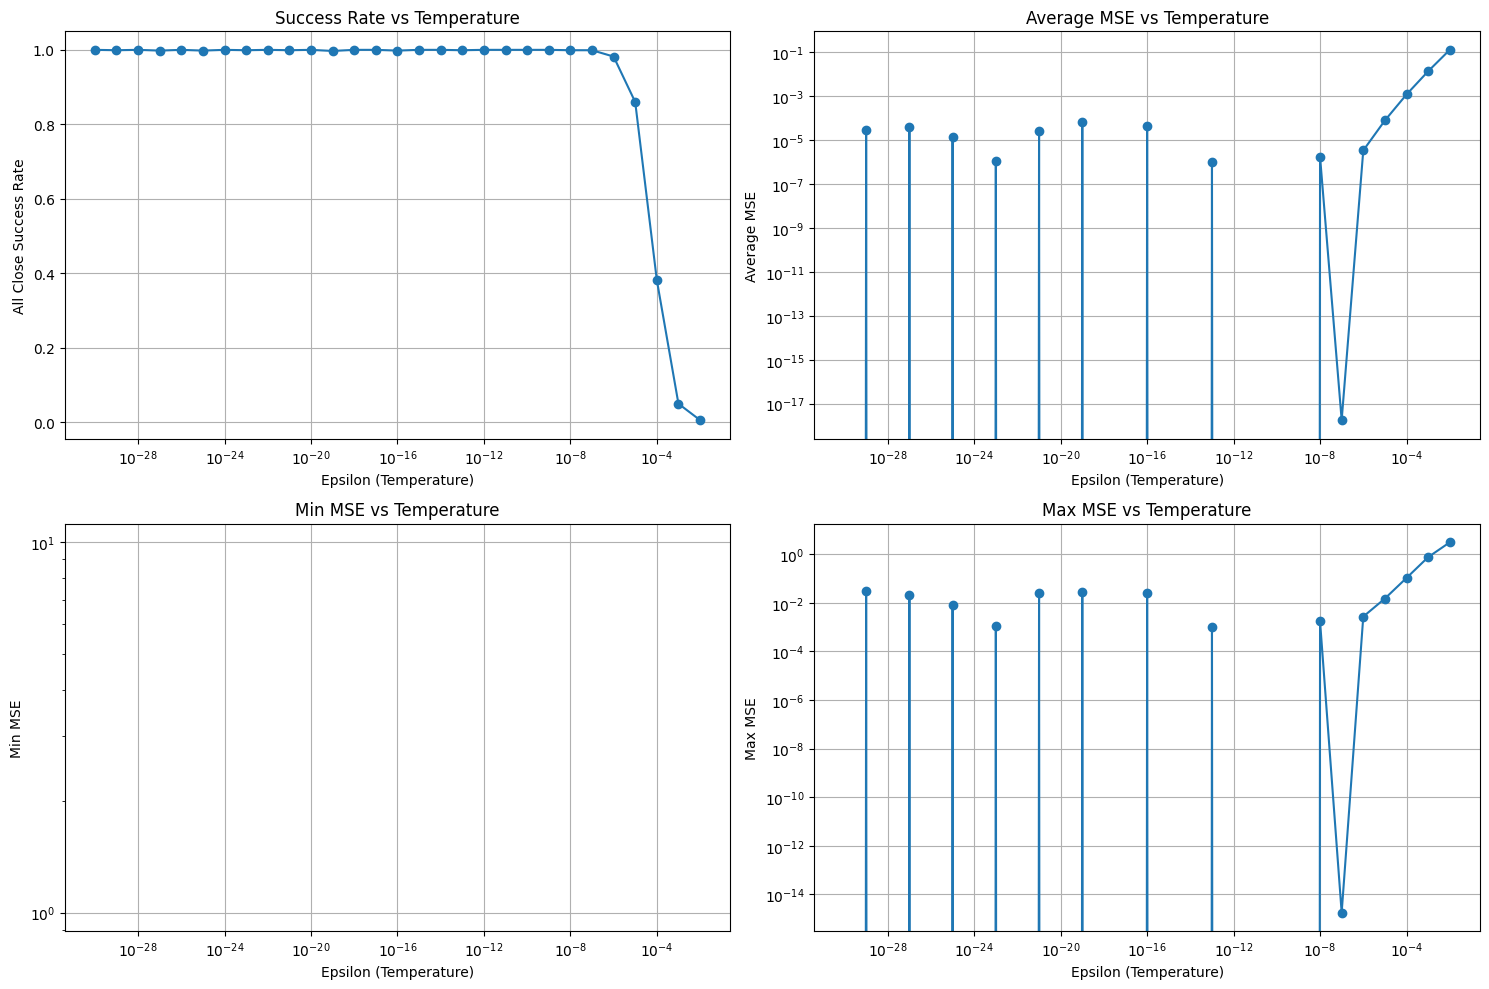

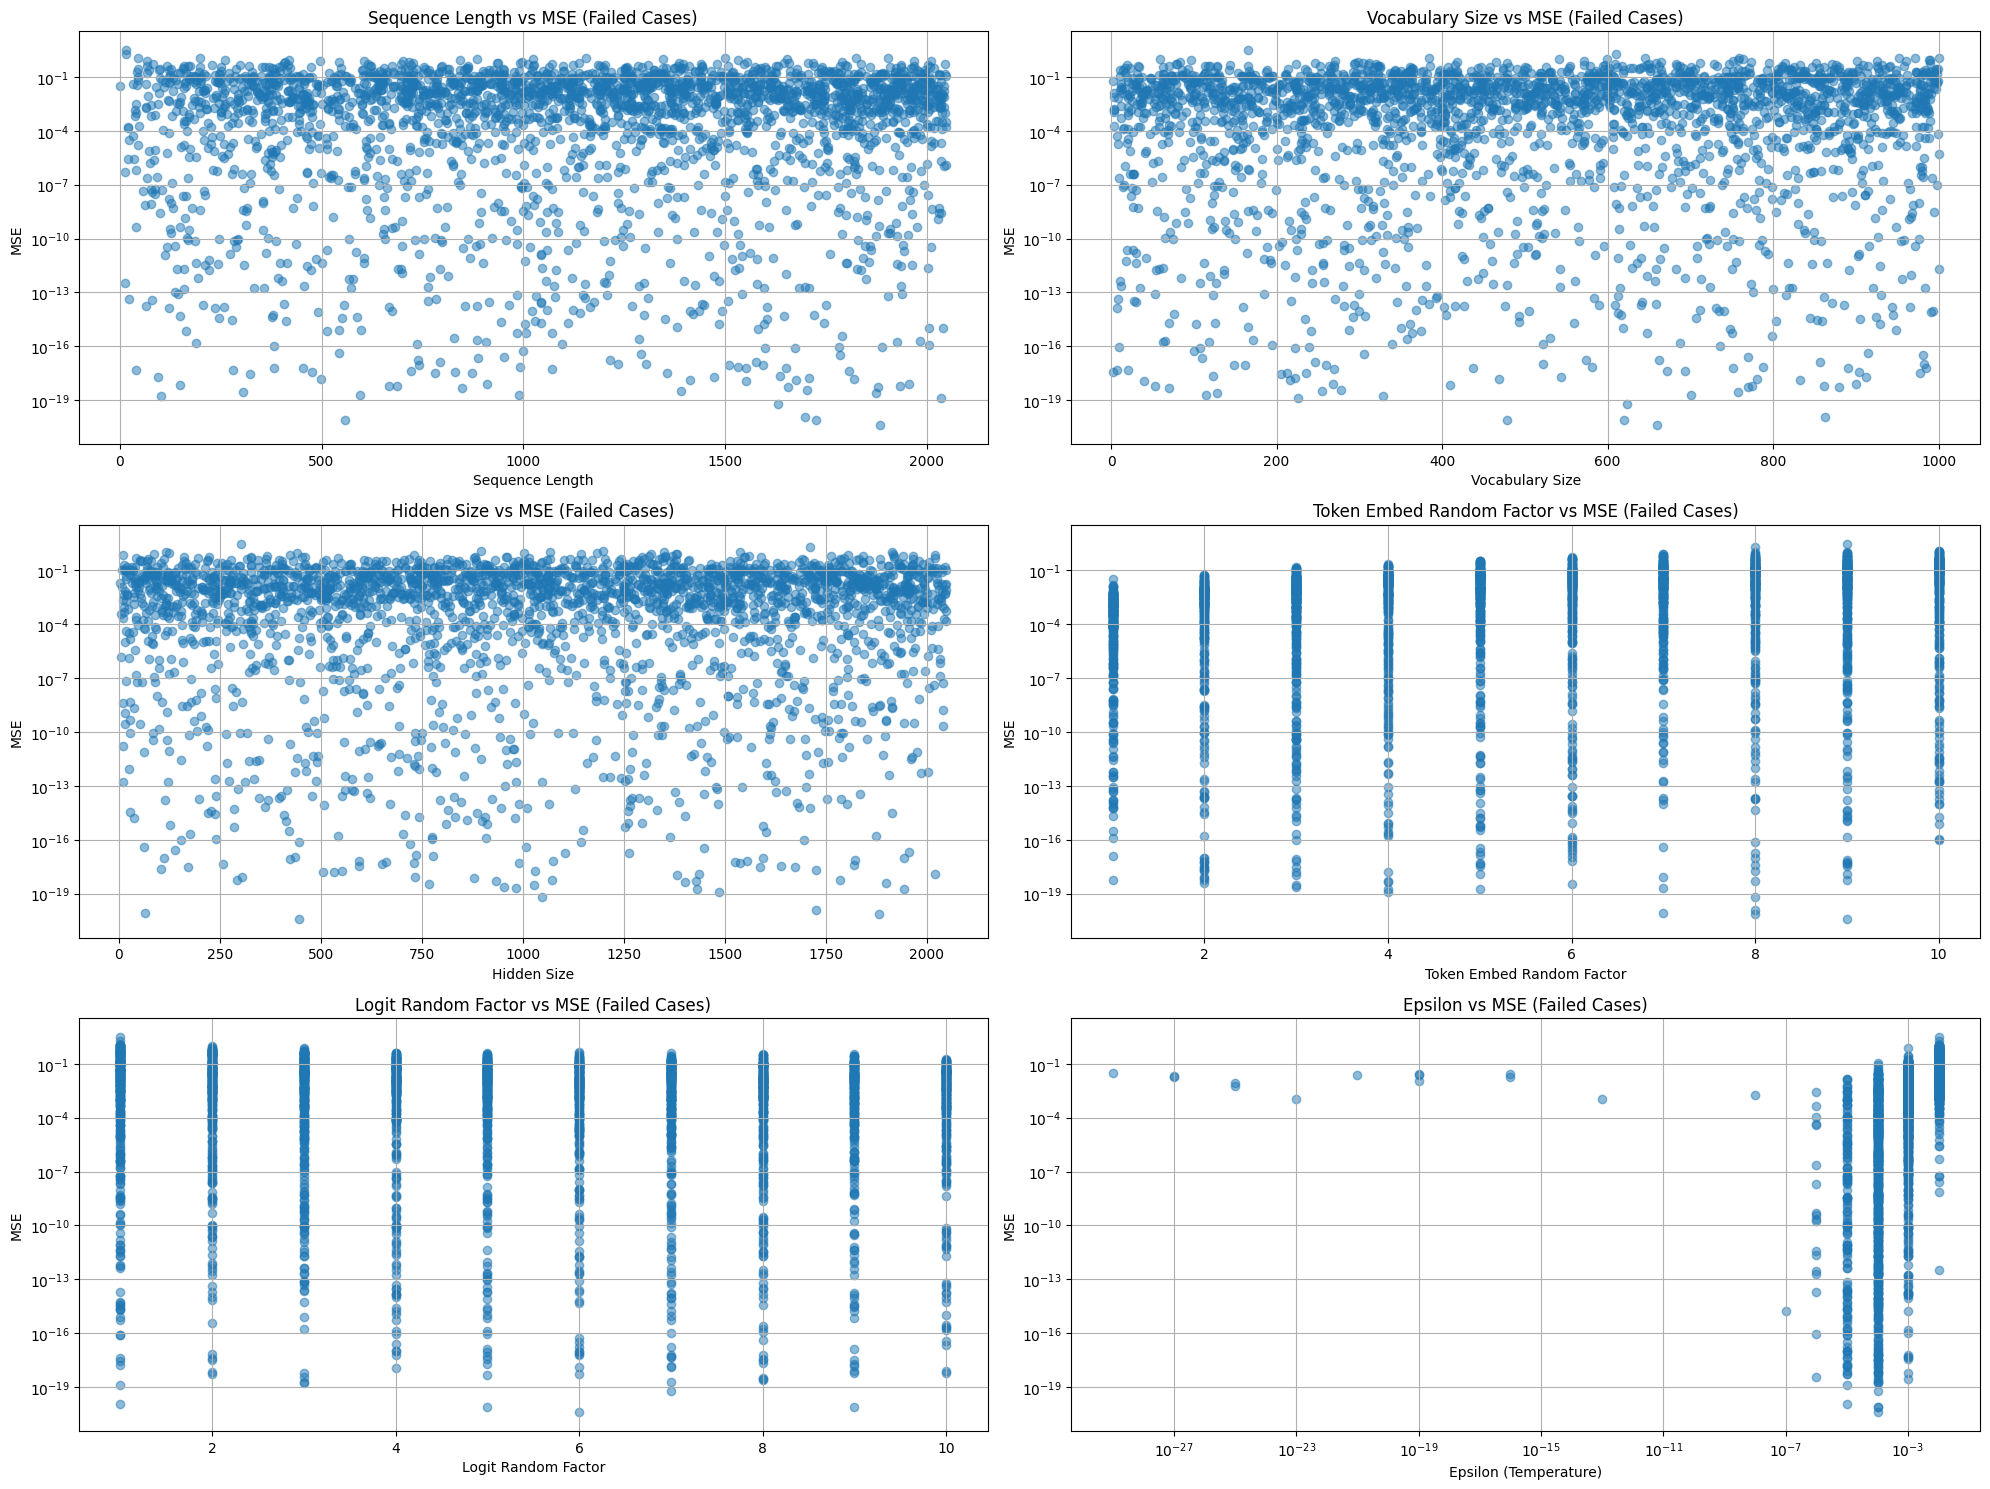

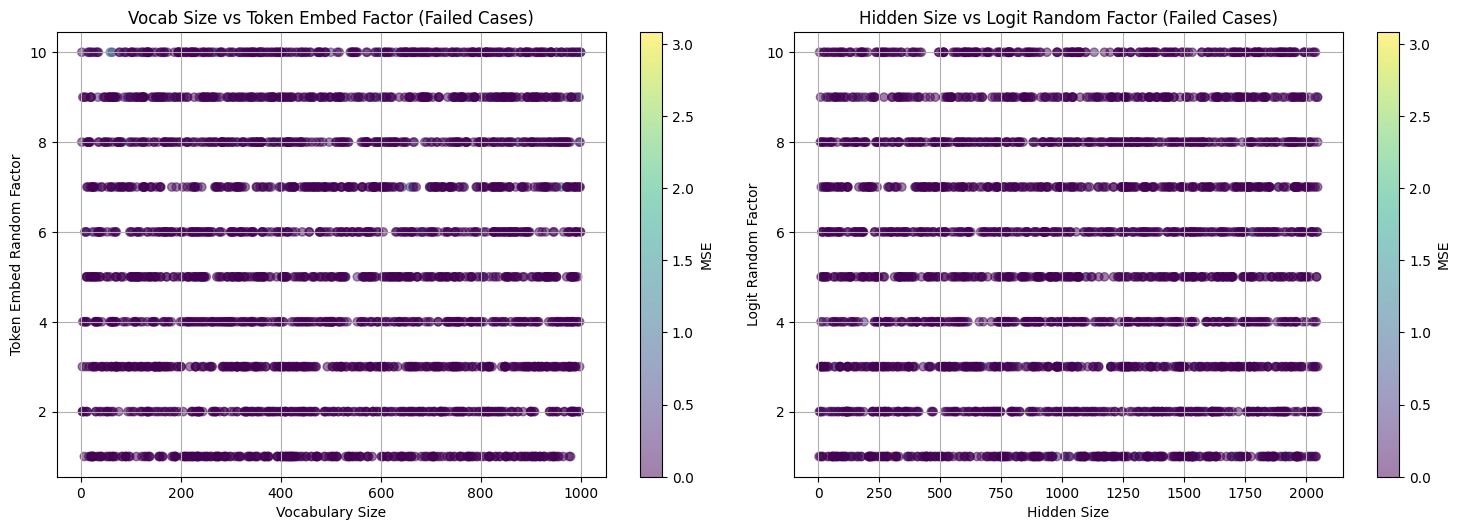


===== Final Results =====
Epsilon 1.00e-02:
  All close success rate: 0.60%
  Average MSE: 1.26867107e-01
  Min MSE: 0.00000000e+00
  Max MSE: 3.08186984e+00

Epsilon 1.00e-03:
  All close success rate: 5.00%
  Average MSE: 1.34222847e-02
  Min MSE: 0.00000000e+00
  Max MSE: 7.57795751e-01

Epsilon 1.00e-04:
  All close success rate: 38.20%
  Average MSE: 1.18055153e-03
  Min MSE: 0.00000000e+00
  Max MSE: 1.05508283e-01

Epsilon 1.00e-05:
  All close success rate: 86.00%
  Average MSE: 7.75606751e-05
  Min MSE: 0.00000000e+00
  Max MSE: 1.50112202e-02

Epsilon 1.00e-06:
  All close success rate: 98.20%
  Average MSE: 3.35152706e-06
  Min MSE: 0.00000000e+00
  Max MSE: 2.70880107e-03

Epsilon 1.00e-07:
  All close success rate: 99.90%
  Average MSE: 1.78420439e-18
  Min MSE: 0.00000000e+00
  Max MSE: 1.78420439e-15

Epsilon 1.00e-08:
  All close success rate: 99.90%
  Average MSE: 1.72239006e-06
  Min MSE: 0.00000000e+00
  Max MSE: 1.72239006e-03

Epsilon 1.00e-09:
  All close success

In [58]:
# Track MSE and allclose results for each iteration
total_iterations = 1000
eps_list = np.logspace(-2, -30, 29).tolist()

# Store results for each epsilon
results = {
    'epsilon': [],
    'all_close_rate': [],
    'avg_mse': [],
    'min_mse': [],
    'max_mse': []
}

# Track parameters for failed cases
failed_cases = {
    'epsilon': [],
    'seq_len': [],
    'vocab_size': [],
    'hidden_size': [],
    'token_embed_random_factor': [],
    'logit_random_factor': [],
    'mse': []
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for eps in tqdm(eps_list):
    print(f"Testing with epsilon: {eps:.2e}")
    all_close_count = 0
    mse_values = []
    
    for i in range(total_iterations):
        seq_len = random.randint(1, 2048)
        vocab_size = random.randint(1, 1000)
        hidden_size = random.randint(1, 2048)
        
        token_embed_random_factor = random.randint(1, 10)
        logit_random_factor = random.randint(1, 10)
        token_embeddings = torch.randn(vocab_size, hidden_size, device=device) * token_embed_random_factor
        logits = torch.randn(seq_len, vocab_size, device=device) * logit_random_factor

        # Method 1: Direct argmax
        preds = torch.argmax(logits, dim=-1)
        pred_embeddings = token_embeddings[preds]

        # Method 2: Differentiable approximation
        diff_preds = low_temp_softmax(logits, eps)  # (seq_len, vocab_size)
        diff_pred_embeddings = diff_preds @ token_embeddings
        
        # Calculate MSE
        mse = F.mse_loss(pred_embeddings, diff_pred_embeddings).item()
        mse_values.append(mse)
        
        # Check if tensors are close
        is_close = torch.allclose(pred_embeddings, diff_pred_embeddings, rtol=1e-6)
        if is_close:
            all_close_count += 1
        else:
            # Track parameters for failed cases
            failed_cases['epsilon'].append(eps)
            failed_cases['seq_len'].append(seq_len)
            failed_cases['vocab_size'].append(vocab_size)
            failed_cases['hidden_size'].append(hidden_size)
            failed_cases['token_embed_random_factor'].append(token_embed_random_factor)
            failed_cases['logit_random_factor'].append(logit_random_factor)
            failed_cases['mse'].append(mse)
    
    # Store results for this epsilon
    close_rate = all_close_count/total_iterations
    avg_mse = sum(mse_values)/len(mse_values) if mse_values else 0
    min_mse_val = min(mse_values) if mse_values else 0
    max_mse_val = max(mse_values) if mse_values else 0
    
    results['epsilon'].append(eps)
    results['all_close_rate'].append(close_rate)
    results['avg_mse'].append(avg_mse)
    results['min_mse'].append(min_mse_val)
    results['max_mse'].append(max_mse_val)
    
    #print(f"Epsilon {eps:.2e}: Close rate {close_rate:.2%}, Avg MSE {avg_mse:.8e}")

# Create plots
plt.figure(figsize=(15, 10))

# Plot 1: All close rate vs epsilon
plt.subplot(2, 2, 1)
plt.semilogx(results['epsilon'], results['all_close_rate'], 'o-')
plt.xlabel('Epsilon (Temperature)')
plt.ylabel('All Close Success Rate')
plt.title('Success Rate vs Temperature')
plt.grid(True)

# Plot 2: Average MSE vs epsilon
plt.subplot(2, 2, 2)
plt.loglog(results['epsilon'], results['avg_mse'], 'o-')
plt.xlabel('Epsilon (Temperature)')
plt.ylabel('Average MSE')
plt.title('Average MSE vs Temperature')
plt.grid(True)

# Plot 3: Min MSE vs epsilon
plt.subplot(2, 2, 3)
plt.loglog(results['epsilon'], results['min_mse'], 'o-')
plt.xlabel('Epsilon (Temperature)')
plt.ylabel('Min MSE')
plt.title('Min MSE vs Temperature')
plt.grid(True)

# Plot 4: Max MSE vs epsilon
plt.subplot(2, 2, 4)
plt.loglog(results['epsilon'], results['max_mse'], 'o-')
plt.xlabel('Epsilon (Temperature)')
plt.ylabel('Max MSE')
plt.title('Max MSE vs Temperature')
plt.grid(True)

plt.tight_layout()
plt.show()

# Create additional plots for failed cases
if failed_cases['epsilon']:
    plt.figure(figsize=(20, 15))
    
    # Plot 1: Sequence Length vs MSE for failed cases
    plt.subplot(3, 2, 1)
    plt.scatter(failed_cases['seq_len'], failed_cases['mse'], alpha=0.5)
    plt.xlabel('Sequence Length')
    plt.ylabel('MSE')
    plt.title('Sequence Length vs MSE (Failed Cases)')
    plt.yscale('log')
    plt.grid(True)
    
    # Plot 2: Vocab Size vs MSE for failed cases
    plt.subplot(3, 2, 2)
    plt.scatter(failed_cases['vocab_size'], failed_cases['mse'], alpha=0.5)
    plt.xlabel('Vocabulary Size')
    plt.ylabel('MSE')
    plt.title('Vocabulary Size vs MSE (Failed Cases)')
    plt.yscale('log')
    plt.grid(True)
    
    # Plot 3: Hidden Size vs MSE for failed cases
    plt.subplot(3, 2, 3)
    plt.scatter(failed_cases['hidden_size'], failed_cases['mse'], alpha=0.5)
    plt.xlabel('Hidden Size')
    plt.ylabel('MSE')
    plt.title('Hidden Size vs MSE (Failed Cases)')
    plt.yscale('log')
    plt.grid(True)
    
    # Plot 4: Token Embed Random Factor vs MSE for failed cases
    plt.subplot(3, 2, 4)
    plt.scatter(failed_cases['token_embed_random_factor'], failed_cases['mse'], alpha=0.5)
    plt.xlabel('Token Embed Random Factor')
    plt.ylabel('MSE')
    plt.title('Token Embed Random Factor vs MSE (Failed Cases)')
    plt.yscale('log')
    plt.grid(True)
    
    # Plot 5: Logit Random Factor vs MSE for failed cases
    plt.subplot(3, 2, 5)
    plt.scatter(failed_cases['logit_random_factor'], failed_cases['mse'], alpha=0.5)
    plt.xlabel('Logit Random Factor')
    plt.ylabel('MSE')
    plt.title('Logit Random Factor vs MSE (Failed Cases)')
    plt.yscale('log')
    plt.grid(True)
    
    # Plot 6: Epsilon vs MSE for failed cases
    plt.subplot(3, 2, 6)
    plt.scatter(failed_cases['epsilon'], failed_cases['mse'], alpha=0.5)
    plt.xlabel('Epsilon (Temperature)')
    plt.ylabel('MSE')
    plt.title('Epsilon vs MSE (Failed Cases)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Additional correlation analysis
    plt.figure(figsize=(15, 10))
    
    # Plot correlation between vocab size and token embed factor
    plt.subplot(2, 2, 1)
    plt.scatter(failed_cases['vocab_size'], failed_cases['token_embed_random_factor'], 
                c=failed_cases['mse'], cmap='viridis', alpha=0.5)
    plt.colorbar(label='MSE')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('Token Embed Random Factor')
    plt.title('Vocab Size vs Token Embed Factor (Failed Cases)')
    plt.grid(True)
    
    # Plot correlation between hidden size and logit random factor
    plt.subplot(2, 2, 2)
    plt.scatter(failed_cases['hidden_size'], failed_cases['logit_random_factor'], 
                c=failed_cases['mse'], cmap='viridis', alpha=0.5)
    plt.colorbar(label='MSE')
    plt.xlabel('Hidden Size')
    plt.ylabel('Logit Random Factor')
    plt.title('Hidden Size vs Logit Random Factor (Failed Cases)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Display final statistics
print("\n===== Final Results =====")
for i, eps in enumerate(results['epsilon']):
    print(f"Epsilon {eps:.2e}:")
    print(f"  All close success rate: {results['all_close_rate'][i]:.2%}")
    print(f"  Average MSE: {results['avg_mse'][i]:.8e}")
    print(f"  Min MSE: {results['min_mse'][i]:.8e}")
    print(f"  Max MSE: {results['max_mse'][i]:.8e}")
    print()

In [66]:
model_paths = [
    'Synthyra/ESM2-8M',
    'Synthyra/ESM2-35M',
    'Synthyra/ESM2-150M',
    'Synthyra/ESM2-650M',
]

tokenizer = AutoTokenizer.from_pretrained('facebook/esm2_t6_8M_UR50D')

data = load_dataset('Synthyra/human_proteome', split='protein').shuffle(seed=42).select(range(100))
seqs = data['Seq']

eps = 1e-6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model_path in model_paths:
    model = AutoModelForMaskedLM.from_pretrained(model_path, trust_remote_code=True).to(device)
    token_embedding_matrix = model.esm.embeddings.word_embeddings.weight # (vocab_size, hidden_size)
    model.eval()

    mse_values = []
    all_close_count = 0

    with torch.no_grad():
        for seq in tqdm(seqs):
            inputs = tokenizer(seq[:1022], return_tensors='pt').to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            pred_embeddings = token_embedding_matrix[preds]

            diff_preds = low_temp_softmax(logits, eps)
            diff_pred_embeddings = diff_preds @ token_embedding_matrix

            mse = F.mse_loss(pred_embeddings, diff_pred_embeddings).item()
            mse_values.append(mse)

            is_close = torch.allclose(pred_embeddings, diff_pred_embeddings, rtol=1e-6)
            if is_close:
                all_close_count += 1

    model.cpu()
    token_embedding_matrix.cpu()
    del model, token_embedding_matrix
    torch.cuda.empty_cache()

    avg_mse = sum(mse_values)/len(mse_values) if mse_values else 0
    close_rate = all_close_count/len(seqs)
    print(f"Average MSE for {model_path}: {avg_mse:.8e}")
    print(f"All close success rate: {close_rate:.2%}")



  0%|          | 0/100 [00:00<?, ?it/s]

Average MSE for Synthyra/ESM2-8M: 0.00000000e+00
All close success rate: 100.00%


  0%|          | 0/100 [00:00<?, ?it/s]

Average MSE for Synthyra/ESM2-35M: 0.00000000e+00
All close success rate: 100.00%


  0%|          | 0/100 [00:00<?, ?it/s]

Average MSE for Synthyra/ESM2-150M: 0.00000000e+00
All close success rate: 100.00%


  0%|          | 0/100 [00:00<?, ?it/s]

Average MSE for Synthyra/ESM2-650M: 0.00000000e+00
All close success rate: 100.00%
